In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import math
import warnings
warnings.filterwarnings('ignore')

In [58]:
LABEL_PATH = "datasets/data1/data1_Class_Labels.txt"
SM_PATH = "datasets/data1/data1_SM.txt"

In [59]:
with open(SM_PATH) as f:
    similarity_data = f.read().splitlines()
similarity_data = np.array([np.array(one_data.split(','), dtype=float) for one_data in similarity_data])

In [60]:
with open(LABEL_PATH) as f:
    label_data = f.read().splitlines()
label_data = np.array(label_data, dtype=float)

In [61]:
similarity_data.shape, label_data.shape

((1000, 1000), (1000,))

In [62]:
min_val, max_val = np.nanmin(similarity_data), np.nanmax(similarity_data)
min_val, max_val

(-3709.8, 29.855)

In [63]:
x, y = np.where(similarity_data > 0)

true_accept_mask = label_data[x] == label_data[y]
zipped = np.array(list(zip(x,y)))
true_accept = zipped[true_accept_mask,:]
false_accept = zipped[~true_accept_mask,:]

x, y = np.where(similarity_data <= 0)

false_reject_mask = label_data[x] == label_data[y]
zipped = np.array(list(zip(x,y)))
if zipped.shape[0]:
    false_reject = zipped[false_reject_mask,:]
    true_reject = zipped[~false_reject_mask,:]
else:
    false_reject = zipped
    true_reject = zipped

In [64]:
true_accept.shape, false_accept.shape, false_reject.shape, true_reject.shape

((2526, 2), (70, 2), (6474, 2), (989930, 2))

In [65]:
all_accept = similarity_data[list(zip(*np.concatenate((true_accept, false_accept),axis=0)))]
all_reject = similarity_data[list(zip(*np.concatenate((false_reject, true_reject),axis=0)))]

In [66]:
all_accept.shape, all_reject.shape

((2596,), (996404,))

In [67]:
t_vals = []
far_vals = []
frr_vals = []
space = np.linspace(min_val, max_val, num=10000)
for t in space:
    FAR_t = all_reject[all_reject > t]
    far_num = FAR_t.shape[0]
    
    FRR_t = all_accept[all_accept < t]
    frr_num = FRR_t.shape[0]
    
    t_vals.append(t)
    far_vals.append(far_num)
    frr_vals.append(frr_num)

t_vals = np.array(t_vals)
far_vals = np.array(far_vals)
frr_vals = np.array(frr_vals)

In [68]:
eer_point = np.argmin(np.abs(frr_vals - far_vals))
eer_t = t_vals[eer_point]
far = far_vals[eer_point]
frr = frr_vals[eer_point]

In [69]:
eer_point, eer_t, far, frr

(9919, -0.06523202320204291, 19, 0)

In [70]:
far_vals[1850:1860], frr_vals[1850:1860]

(array([996006, 996006, 996004, 996002, 995999, 995998, 995996, 995994,
        995990, 995990]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

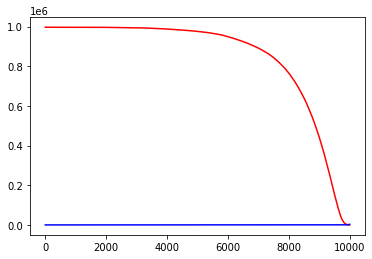

In [73]:
plt.plot(far_vals, "r-", frr_vals, "b-")
plt.show()